In [18]:
from unityagents import UnityEnvironment
env_file = "Tennis_Windows_x86_64\Tennis.exe" #'Tennis_Linux/Tennis.x86_64'#
env = UnityEnvironment(file_name=env_file, no_graphics = False)

OSError: handle is closed

ERROR:root:Exception calling application: [WinError 232] The pipe is being closed
Traceback (most recent call last):
  File "C:\Users\HCRuiz\Anaconda2\envs\drlnd\lib\site-packages\grpc\_server.py", line 385, in _call_behavior
    return behavior(argument, context), True
  File "C:\Users\HCRuiz\Anaconda2\envs\drlnd\lib\site-packages\unityagents\rpc_communicator.py", line 25, in Exchange
    self.child_conn.send(request)
  File "C:\Users\HCRuiz\Anaconda2\envs\drlnd\lib\multiprocessing\connection.py", line 206, in send
    self._send_bytes(_ForkingPickler.dumps(obj))
  File "C:\Users\HCRuiz\Anaconda2\envs\drlnd\lib\multiprocessing\connection.py", line 280, in _send_bytes
    ov, err = _winapi.WriteFile(self._handle, buf, overlapped=True)
BrokenPipeError: [WinError 232] The pipe is being closed


In [2]:
import torch
import numpy as np
from collections import deque
import progressbar as pb
import matplotlib.pyplot as plt
from utils import OUprocess, Reply_buffer
from Tennis_agent import SelfPlay_Agent

using device:  cpu
NO grad. clipping used.


In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('states shape: ',states.shape)
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])
print('The state for the second agent looks like:', states[1])

Number of agents: 2
Size of each action: 2
states shape:  (2, 24)
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]
The state for the second agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.4669857  -1.5
  0.          0.         -6.83172083  6.          0.          0.        ]


In [4]:
T_max = 1000
max_buffer = int(1.e+6)
buffer = Reply_buffer(max_buffer)
noise_decay = 1#0.999
noise_lvl = 0.2
ouA = OUprocess(action_size, sigma=noise_lvl)
ouB = OUprocess(action_size, sigma=noise_lvl)
batch_size = 512
update_steps = 5  #with (128,5,10,5e-4,5e-4) -> 0.23 @ 600 episodes
GD_steps = 2 #with (128,5,2,5e-4,5e-4) -> 0.25 @ 600 episodes
lra=3.e-4
lrc=3.e-4
agent = SelfPlay_Agent(state_size, action_size, num_agents, tau=1, lr_act=lra, lr_crit=lrc)

nr_episodes = 600

In [5]:

widget = ['training loop: ', pb.Percentage(), ' ', pb.Bar()]#, ' ', pb.ETA() ]
timer = pb.ProgressBar(widgets=widget, maxval=nr_episodes).start()
min_buffer = num_agents*batch_size
assert min_buffer<max_buffer, 'minimal length of buffer for update (min_buffer) smaller than buffer memory (max_buffer)!'
ACloss = []
l_exists = False
e_score = np.zeros(nr_episodes)
rolling_avg = np.zeros(nr_episodes)
rolling_window = deque(maxlen=100)
t=0
for i in range(nr_episodes):                                         # play game for nr_episodes episodes
    env_info = env.reset(train_mode=True)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    ouA.reset()
    ouB.reset()
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:#t<T_max:
        t+=1
        # select action
        agent.actor.eval()
        actA  = agent.act(states[np.newaxis,0]).data.cpu().numpy() + ouA.noise()
        actB = agent.act(states[np.newaxis,1]).data.cpu().numpy() + ouB.noise()
        actions = np.clip([actA[0], actB[0]],-1,1) # select an action (for each agent)
        # execute and observe
        #actions = [np.array([0.1,1]),np.array([0.1,1])]
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        # store in replay buffer
        samples = [states, np.asarray(actions), np.asarray(rewards), next_states, dones]
        buffer.store(samples)
        # roll over states to next time step
        states = next_states                               
        # keep track of scores
        scores += env_info.rewards                         # update the score (for each agent)
        # Update agents
        if ((t-1) % update_steps == 0) and len(buffer.buffer) > batch_size:
            l_exists = True
            agent.actor.train()
            #for a_i in np.random.permutation(num_agents): #ideally you would like to sample the agents randomly 
            for ep in range(GD_steps):
                minibatch = buffer.get_batch(batch_size)  # get batch of size (batch_size x 5) where the 2nd dim corresponds to (s,a,r,s',done)
                agent_i = np.random.choice(num_agents,len(minibatch))
                closs = agent.update_critic(minibatch,agent_i)
                aloss = agent.update_actor(minibatch,agent_i)
            #ACloss.append([aloss,closs])
                    
        # Update target network
        if agent.tau == 1 and t% int(2*update_steps) == 0:
            agent.target_update()
        else:
            agent.target_update()
        # exit loop if episode finished
        if np.any(dones): 
            break
    
    if l_exists:
        ACloss.append([aloss,closs])

    ouA.sigma *= noise_decay
    ouB.sigma *= noise_decay
    
    e_score[i] = np.max(scores)
    rolling_window.append(e_score[i])
    rolling_avg[i] = np.mean(np.array(rolling_window))
    if (i+1) % 20 == 0:
        print('Total score (averaged over agents) episode {}: {}'.format(i+1,np.mean(scores)))
        print('Score (max over agents) from episode {}: {}'.format(i+1, e_score[i]))
        print('Rolling average score: {}'.format(rolling_avg[i]))
        print('Noise level: ',ouA.sigma,ouB.sigma)
        if l_exists:
            print("Actor loss: {} | Critic loss: {}".format(*ACloss[-1]))
    
    # update progress widget bar
    timer.update(i+1)
    
timer.finish()

Total score (averaged over agents) episode 20: -0.004999999888241291
Score (max over agents) from episode 20: 0.0
Rolling average score: 0.010000000149011612
Noise level:  0.2 0.2


Total score (averaged over agents) episode 40: -0.004999999888241291
Score (max over agents) from episode 40: 0.0
Rolling average score: 0.012000000197440385
Noise level:  0.2 0.2
Actor loss: -0.005008896812796593 | Critic loss: 5.2590967243304476e-05


Total score (averaged over agents) episode 60: -0.004999999888241291
Score (max over agents) from episode 60: 0.0
Rolling average score: 0.011333333514630794
Noise level:  0.2 0.2
Actor loss: -0.008619008585810661 | Critic loss: 4.5175791456131265e-05


Total score (averaged over agents) episode 80: 0.04500000085681677
Score (max over agents) from episode 80: 0.10000000149011612
Rolling average score: 0.019500000309199093
Noise level:  0.2 0.2
Actor loss: -0.013581211678683758 | Critic loss: 9.634933667257428e-05


Total score (averaged over agents) episode 100: -0.004999999888241291
Score (max over agents) from episode 100: 0.0
Rolling average score: 0.0222000003606081
Noise level:  0.2 0.2
Actor loss: -0.019398698583245277 | Critic loss: 0.0003443041059654206


Total score (averaged over agents) episode 120: -0.004999999888241291
Score (max over agents) from episode 120: 0.0
Rolling average score: 0.024100000392645596
Noise level:  0.2 0.2
Actor loss: -0.03596445173025131 | Critic loss: 0.00010593145270831883


Total score (averaged over agents) episode 140: -0.004999999888241291
Score (max over agents) from episode 140: 0.0
Rolling average score: 0.022300000358372925
Noise level:  0.2 0.2
Actor loss: -0.027339212596416473 | Critic loss: 0.00013068740372546017


Total score (averaged over agents) episode 160: -0.004999999888241291
Score (max over agents) from episode 160: 0.0
Rolling average score: 0.025200000405311583
Noise level:  0.2 0.2
Actor loss: -0.032761748880147934 | Critic loss: 0.00016624914132989943


Total score (averaged over agents) episode 180: 0.19500000309199095
Score (max over agents) from episode 180: 0.20000000298023224
Rolling average score: 0.02320000037550926
Noise level:  0.2 0.2
Actor loss: -0.041393402963876724 | Critic loss: 0.00017324835062026978


Total score (averaged over agents) episode 200: -0.004999999888241291
Score (max over agents) from episode 200: 0.0
Rolling average score: 0.02250000035390258
Noise level:  0.2 0.2
Actor loss: -0.05705695226788521 | Critic loss: 0.00019816002168226987


Total score (averaged over agents) episode 220: -0.004999999888241291
Score (max over agents) from episode 220: 0.0
Rolling average score: 0.027500000447034836
Noise level:  0.2 0.2
Actor loss: -0.06034303456544876 | Critic loss: 0.00022804226318839937


Total score (averaged over agents) episode 240: 0.04500000085681677
Score (max over agents) from episode 240: 0.10000000149011612
Rolling average score: 0.033200000543147326
Noise level:  0.2 0.2
Actor loss: -0.06389360874891281 | Critic loss: 0.00024603906786069274


Total score (averaged over agents) episode 260: 0.1450000023469329
Score (max over agents) from episode 260: 0.20000000298023224
Rolling average score: 0.04310000069439411
Noise level:  0.2 0.2
Actor loss: -0.07365615665912628 | Critic loss: 0.0003278127987869084


Total score (averaged over agents) episode 280: 0.09500000160187483
Score (max over agents) from episode 280: 0.10000000149011612
Rolling average score: 0.05600000090897083
Noise level:  0.2 0.2
Actor loss: -0.07815134525299072 | Critic loss: 0.0001361877511953935


Total score (averaged over agents) episode 300: 0.1450000023469329
Score (max over agents) from episode 300: 0.19000000320374966
Rolling average score: 0.06790000109001994
Noise level:  0.2 0.2
Actor loss: -0.09354924410581589 | Critic loss: 0.0003556135343387723


Total score (averaged over agents) episode 320: 0.04500000085681677
Score (max over agents) from episode 320: 0.10000000149011612
Rolling average score: 0.0798000012524426
Noise level:  0.2 0.2
Actor loss: -0.07500481605529785 | Critic loss: 0.00025268198805861175


Total score (averaged over agents) episode 340: 0.1450000023469329
Score (max over agents) from episode 340: 0.20000000298023224
Rolling average score: 0.09390000145882368
Noise level:  0.2 0.2
Actor loss: -0.10754535347223282 | Critic loss: 0.00035276298876851797


Total score (averaged over agents) episode 360: 0.09500000160187483
Score (max over agents) from episode 360: 0.10000000149011612
Rolling average score: 0.10080000156536699
Noise level:  0.2 0.2
Actor loss: -0.11629003286361694 | Critic loss: 0.0003458719002082944


Total score (averaged over agents) episode 380: 0.44500000681728125
Score (max over agents) from episode 380: 0.5000000074505806
Rolling average score: 0.11670000178739429
Noise level:  0.2 0.2
Actor loss: -0.11268004775047302 | Critic loss: 0.00034244981361553073


Total score (averaged over agents) episode 400: 0.09500000160187483
Score (max over agents) from episode 400: 0.10000000149011612
Rolling average score: 0.13960000213235615
Noise level:  0.2 0.2
Actor loss: -0.13971436023712158 | Critic loss: 0.00027619293541647494


Total score (averaged over agents) episode 420: 0.19500000309199095
Score (max over agents) from episode 420: 0.20000000298023224
Rolling average score: 0.14870000226423144
Noise level:  0.2 0.2
Actor loss: -0.19437234103679657 | Critic loss: 0.000430145621066913


Total score (averaged over agents) episode 440: 0.04500000085681677
Score (max over agents) from episode 440: 0.10000000149011612
Rolling average score: 0.15370000233873726
Noise level:  0.2 0.2
Actor loss: -0.202104389667511 | Critic loss: 0.0005073812790215015


Total score (averaged over agents) episode 460: 0.09500000160187483
Score (max over agents) from episode 460: 0.10000000149011612
Rolling average score: 0.1569000023789704
Noise level:  0.2 0.2
Actor loss: -0.1965043544769287 | Critic loss: 0.00036045664455741644


Total score (averaged over agents) episode 480: 0.09500000160187483
Score (max over agents) from episode 480: 0.10000000149011612
Rolling average score: 0.14980000227689744
Noise level:  0.2 0.2
Actor loss: -0.1913706511259079 | Critic loss: 0.00043927549268119037


Total score (averaged over agents) episode 500: 0.09500000160187483
Score (max over agents) from episode 500: 0.10000000149011612
Rolling average score: 0.14190000215545295
Noise level:  0.2 0.2
Actor loss: -0.20974686741828918 | Critic loss: 0.0004876102029811591


Total score (averaged over agents) episode 520: 0.09500000160187483
Score (max over agents) from episode 520: 0.10000000149011612
Rolling average score: 0.13790000209584832
Noise level:  0.2 0.2
Actor loss: -0.21447895467281342 | Critic loss: 0.0002816123887896538


Total score (averaged over agents) episode 540: 0.04500000085681677
Score (max over agents) from episode 540: 0.10000000149011612
Rolling average score: 0.12970000198110937
Noise level:  0.2 0.2
Actor loss: -0.18651148676872253 | Critic loss: 0.0006198827177286148


Total score (averaged over agents) episode 560: 0.04500000085681677
Score (max over agents) from episode 560: 0.10000000149011612
Rolling average score: 0.13670000208541752
Noise level:  0.2 0.2
Actor loss: -0.1829097419977188 | Critic loss: 0.000579751271288842


Total score (averaged over agents) episode 580: -0.004999999888241291
Score (max over agents) from episode 580: 0.0
Rolling average score: 0.13010000197216867
Noise level:  0.2 0.2
Actor loss: -0.2015775442123413 | Critic loss: 0.0006409630877897143


Total score (averaged over agents) episode 600: 0.04500000085681677
Score (max over agents) from episode 600: 0.09000000171363354
Rolling average score: 0.11820000179111957
Noise level:  0.2 0.2
Actor loss: -0.20771870017051697 | Critic loss: 0.00042294617742300034


In [6]:
print(actions)
print(actA)
print(actB)

[[-1.         -1.        ]
 [-0.50445435  0.42952242]]
[[-1.29359243 -1.2185474 ]]
[[-0.50445435  0.42952242]]


(568, 2)


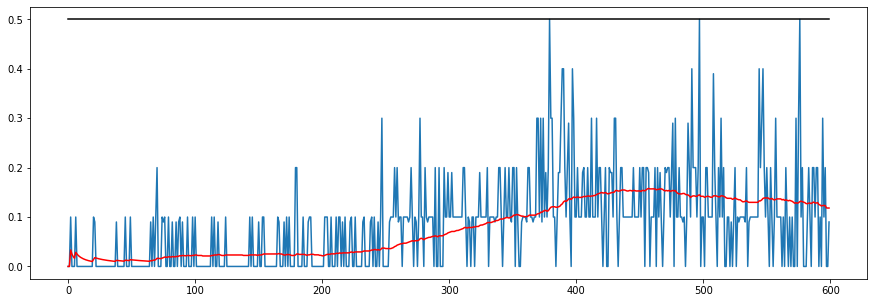

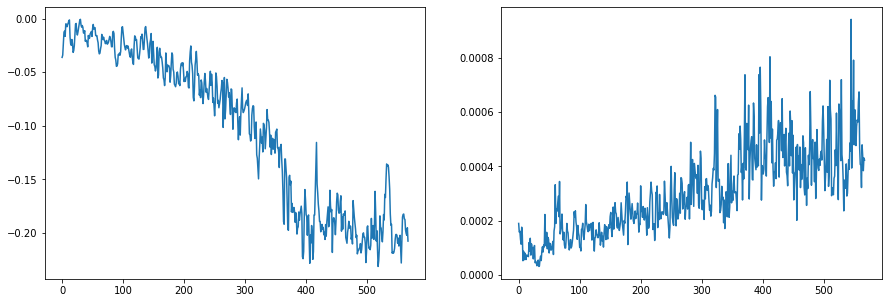

In [7]:
ACloss = np.asarray(ACloss)
print(ACloss.shape)
plt.figure(figsize=(15,5))
plt.plot(e_score)
plt.plot(rolling_avg,'r')
plt.plot(0.5*np.ones_like(rolling_avg),'k')
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(ACloss[:,0])
plt.subplot(122)
plt.plot(ACloss[:,1])


In [8]:
# env.close()
print('lra {}, lrc {}, noise_lvl {}, noise_decay {}, batch_size {}, update_steps {}, GD_steps {}'.format(lra, lrc, noise_lvl,noise_decay,batch_size,
                                                                                         update_steps,GD_steps))

lra 0.001, lrc 0.001, noise_lvl 0.2, noise_decay 1, batch_size 512, update_steps 5, GD_steps 2


In [9]:
len(buffer.buffer)

25112

In [10]:
print(t)

25112


In [11]:
for param_grp in agent.actor_optim.param_groups:
    print(param_grp['lr'])
for param_grp in agent.critic_optim.param_groups:
    print(param_grp['lr'])

0.001
0.001


In [12]:
rolling_avg.max()

0.15790000239387156

lra 0.0005, lrc 0.0005, noise_lvl 0.2, noise_decay 1, batch_size 128, update_steps 1, GD_steps 2 => 0.25

In [16]:
T_max = 2000
agent.actor.eval()
for i in range(10):                                         # play game for nr_episodes episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    ouA.reset()
    ouB.reset()
    while True:#t<T_max:
        t+=1
        # select action
        actA  = agent.act(states[np.newaxis,0]).data.cpu().numpy() + ouA.noise()
        actB = agent.act(states[np.newaxis,1]).data.cpu().numpy() + ouB.noise()
        actions = np.clip([actA[0], actB[0]],-1,1) # select an action (for each agent)
        # execute and observe
        #actions = [np.array([0.1,1]),np.array([0.1,1])]
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        # roll over states to next time step
        states = next_states                               
        # keep track of scores
        scores += env_info.rewards                         # update the score (for each agent)
        # exit loop if episode finished
        if np.any(dones): 
            break
    print('Best player score in episode {}: {}'.format(i,np.max(scores)))

UnityEnvironmentException: No Unity environment is loaded.

In [14]:
# env.close()

In [15]:
print('Best player score in episode {}: {}'.format(i,np.max(scores)))

Best player score in episode 0: 0.0
